# Classifier

1. Logistic regression (https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python)


functions:
https://scikit-learn.org/stable/modules/feature_selection.html

example:
https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html#sphx-glr-auto-examples-feature-selection-plot-feature-selection-py

tut:
https://medium.com/@GouthamPeri/pipeline-with-tuning-scikit-learn-b2789dca9dc2

https://stackoverflow.com/questions/33376078/python-feature-selection-in-pipeline-how-determine-feature-names


https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html#sphx-glr-auto-examples-model-selection-grid-search-text-feature-extraction-py

## Import packages

In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import random
random.seed(32)
import sklearn
# from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_curve, roc_auc_score, plot_roc_curve, plot_confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Import data

In [2]:
df = pd.read_pickle("wordlists_lin_feat_df_withoutuserfeat_allcomments.pkl")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1606 entries, -Areopagan- to zyzee
Columns: 103888 entries, body to mrc_pmean
dtypes: float64(87790), int64(16092), object(6)
memory usage: 1.2+ GB


In [3]:
# predictors = df.columns.tolist()
# i = 0
# predictorsfile=open('predictorslist.txt','w')
# # predictorsfile.writelines(predictors)
# for element in predictors:
#     predictorsfile.write(str(i))
#     predictorsfile.write(" ")
#     predictorsfile.write(element)
#     predictorsfile.write('\n')
#     i+=1
# predictorsfile.close()

In [4]:
# multilevel columns

lst1 = (5)*["data"]
lst9 = (15-5)*["traits"]
lst10 = ["data"]
lst2 = (21-17)*["global"]
lst3 = (45-21)*["time"]
lst4 = (16103-45)*["subreddits"]
lst5 = (16116-16103)*["extra_features"]
lst6 = (96308-16116)*["word_ngrams"]
lst7 = (103829-96308)*["char_ngrams"]
lst8 = (103889-103829)*["wordlists"]
headers = lst1 + lst9  + lst10 + lst2 + lst3 + lst4 +lst5 + lst6 + lst7 + lst8 
columns = df.columns.values
print(len(headers))
print(len(columns))
arrays = [headers] + [columns]
df.columns=pd.MultiIndex.from_arrays(arrays)

103888
103888


In [5]:
test = df.columns

In [6]:
df['traits', 'agree5'] = df['traits', 'agreeableness'].apply(lambda x: 0 if x<20 else(1 if x>19 and x<40 else(2 if x>39 and x<60 else(3 if x>59 and x<80 else 4))))
df['traits', 'openn5'] = df['traits', 'openness'].apply(lambda x: 0 if x<20 else(1 if x>19 and x<40 else(2 if x>39 and x<60 else(3 if x>59 and x<80 else 4))))
df['traits', 'consc5'] = df['traits', 'conscientiousness'].apply(lambda x: 0 if x<20 else(1 if x>19 and x<40 else(2 if x>39 and x<60 else(3 if x>59 and x<80 else 4))))
df['traits', 'extra5'] = df['traits', 'extraversion'].apply(lambda x: 0 if x<20 else(1 if x>19 and x<40 else(2 if x>39 and x<60 else(3 if x>59 and x<80 else 4))))
df['traits', 'neuro5'] = df['traits', 'neuroticism'].apply(lambda x: 0 if x<20 else(1 if x>19 and x<40 else(2 if x>39 and x<60 else(3 if x>59 and x<80 else 4))))

In [7]:
smalldf = df[['traits', 'global', 'time', 'extra_features', 'word_ngrams', 'char_ngrams', 'wordlists']]
smalldf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1606 entries, -Areopagan- to zyzee
Columns: 87829 entries, ('traits', 'agreeableness') to ('wordlists', 'mrc_pmean')
dtypes: float64(87788), int64(41)
memory usage: 1.1+ GB


In [8]:
n_bins = 20

def hist_true(df, trait):
    fig, ax = plt.subplots()
    plt.hist(df[trait], bins = 20)
    plt.title(trait, y=1.1)
    plt.xlabel("score")

# hist_true(df, "openn")

def all_hist_true(df):
    plt.figure(figsize = (16, 16))
#     plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.subplot(3, 2, 1)
    plt.hist(df['traits', 'openness'], bins = 20)
    plt.title('Agreeableness')
    
    plt.subplot(3, 2, 2)
    plt.hist(df['traits', 'conscientiousness'], bins = 20)
    plt.title('Openness')
    
    plt.subplot(3, 2, 3)
    plt.hist(df['traits', 'extraversion'], bins = 20)
    plt.title('Conscientiousness')
    
    plt.subplot(3, 2, 4)
    plt.hist(df['traits', 'agreeableness'], bins = 20)
    plt.title('Extraversion')
    
    plt.subplot(3, 2, 5)
    plt.hist(df['traits', 'neuroticism'], bins = 20)
    plt.title('Neuroticism')
    
    plt.suptitle("Histograms of the true trait values")
    plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.4,  
                    hspace=0.4) 
    plt.show()

## Trait

In [9]:
#split dataset in features and target variable depending on which trait to focus on
def trait(df, classes, trait_name):
    featuredf = df.drop(['data', 'traits'], axis=1, level=0)
#     df.drop('traits', axis=1)
#     featuredf = df[['global', 'time', 'subreddits', 'extra_features', 'word_ngrams', 'char_ngrams', 'wordlists']]
#     featuredf = df.loc[:, df.columns != ['data', 'traits']]
#     featuredf = df.loc[:, df.columns != 'data']
#     featuredf = featuredf.loc[:, featuredf.columns != 'traits']
    feature_cols = featuredf.columns.tolist()
    
    x = df[feature_cols] 
    
    if classes=='binary':
    
        if trait_name == 'agreeableness':
            y = df['traits', 'agree']
        elif trait_name == 'openness':
            y = df['traits', 'openn']
        elif trait_name == 'conscientiousness':
            y = df['traits', 'consc']
        elif trait_name == 'extraversion':
            y = df['traits', 'extra']
        elif trait_name == 'neuroticism':
            y = df['traits', 'neuro']   
    else:
        if trait_name == 'agreeableness':
            y = df['traits', 'agree5']
        elif trait_name == 'openness':
            y = df['traits', 'openn5']
        elif trait_name == 'conscientiousness':
            y = df['traits', 'consc5']
        elif trait_name == 'extraversion':
            y = df['traits', 'extra5']
        elif trait_name == 'neuroticism':
            y = df['traits', 'neuro5'] 
    return x,y 

## Classifier

In [10]:
# ANOVA feature selection for numeric input and categorical output

def create_pipeline(x_train, y_train, classifier, num_feat, weighted):
    if weighted==True: 
        if classifier == "log":
            pipeline = Pipeline([
              ('variance_threshold', VarianceThreshold()),
              ('scaler', StandardScaler()),
              ('feature_selection',  SelectKBest(f_classif, k=num_feat)),
              ('classification', LogisticRegression(class_weight='balanced', max_iter = 200, n_jobs=-1))
            ])
        elif classifier == "multilog":
            pipeline = Pipeline([
              ('variance_threshold', VarianceThreshold()),
              ('scaler', StandardScaler()),
              ('feature_selection',  SelectKBest(f_classif, k=num_feat)),
              
              ('classification', LogisticRegression(class_weight='balanced', multi_class='multinomial', 
                                                    max_iter = 200, solver='lbfgs', n_jobs=-1))
            ])
        elif classifier == "knn":
            pipeline = Pipeline([
              ('variance_threshold', VarianceThreshold()),
              ('scaler', StandardScaler()),
              ('feature_selection',  SelectKBest(f_classif, k=num_feat)),
              ('classification', KNeighborsClassifier(class_weight='balanced', n_neighbors=1, n_jobs=-1))
            ])

    else:
        if classifier == "log":
            pipeline = Pipeline([
              ('variance_threshold', VarianceThreshold()),
              ('scaler', StandardScaler()),
              ('feature_selection',  SelectKBest(f_classif, k=num_feat)),
              ('classification', LogisticRegression(max_iter = 200, n_jobs=-1))
            ])
        elif classifier == "multilog":
            pipeline = Pipeline([
              ('variance_threshold', VarianceThreshold()),
              ('scaler', StandardScaler()),
              ('feature_selection',  SelectKBest(f_classif, k=num_feat)),
              ('classification', LogisticRegression(multi_class='multinomial', max_iter = 200, solver='lbfgs', 
                                                    n_jobs=-1))
            ])
        elif classifier == "mlp":
            pipeline = Pipeline([
              ('variance_threshold', VarianceThreshold()),
              ('scaler', StandardScaler()),
              ('feature_selection',  SelectKBest(f_classif, k=num_feat)),
              ('classification', MLPClassifier())
            ])
        elif classifier == "knn":
            pipeline = Pipeline([
              ('variance_threshold', VarianceThreshold()),
              ('scaler', StandardScaler()),
              ('feature_selection',  SelectKBest(f_classif, k=num_feat)),
              ('classification', KNeighborsClassifier(n_neighbors=1, n_jobs=-1))
            ])
        
    pipeline.fit(x_train, y_train)
    return pipeline

## Get names of 30 most important features

In [11]:
# get names of the features
def get_names(x, pipeline):
    features = pipeline.named_steps['feature_selection']
    names = x.columns[features.get_support(indices=True)]
    return names
# names = get_names(logpipe)
# print(names)

### Get p-values

In [12]:
def get_pvalues(pipeline, x):
#     x_indices = np.arange(x.shape[-1])
#     selector = SelectKBest(f_classif, k=30)
#     selector.fit(x_train, y_train)
#     scores = -np.log10(selector.pvalues_)
    features = pipeline.named_steps['feature_selection']
    pvalues = features.pvalues_
#     pvalues /= pvalues.max()
    dfpvalues = pd.DataFrame(features.pvalues_)
    dfscores = pd.DataFrame(features.scores_)
    dfcolumns = pd.DataFrame(x.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores, dfpvalues],axis=1)
    featureScores.columns = ['specs','score', 'pvalue']
    featureScores.sort_values(by='pvalue')

    plt.figure(figsize = (12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(pvalues, bins=20)
    plt.title('All p-values')
    plt.subplot(1, 2, 2)
    smallpvalues = pvalues[pvalues<0.1]
    plt.hist(smallpvalues, bins=10)
    plt.title('Small p-values')
    
    plt.suptitle("Histograms of the p-values")
    plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.4,  
                    hspace=0.4) 
    plt.show()
    
    return featureScores

## Scores

In [13]:
def scores(y_test, y_pred, presentationtype):
    
    if presentationtype == "scores":
        accuracy=metrics.accuracy_score(y_test, y_pred)
        precision=metrics.precision_score(y_test, y_pred)
        recall=metrics.recall_score(y_test, y_pred)
        f_one=metrics.f1_score(y_test, y_pred)
        return accuracy, precision, recall, f_one
    if presentationtype == "report":
        report = classification_report(y_test, y_pred)
        return report


def score_plot(logreg, y_test, x_test):
    lr_probs = logreg.predict_proba(x_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # predict class values
#     yhat = logreg.predict(x_test)
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
#     lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)

    # plot the precision-recall curves
    no_skill = len(y_test[y_test==1]) / len(y_test)
    fig, ax = plt.subplots()
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(lr_recall, lr_precision, marker='.', label='Classifier')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    plt.show()
    
    return lr_precision, lr_recall


### Score plot
Smaller values on the x-axis of the plot indicate lower false positives and higher true negatives.


Larger values on the y-axis of the plot indicate higher true positives and lower false negatives.

## Create and print confusion matrix

In [14]:
def create_cnfmatrix(clf, x_test, y_test, y_pred, plotting, detailed):
    cnfpipe_matrix = metrics.confusion_matrix(y_test, y_pred)
#     print(cnfpipe_matrix)
#     disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cnfpipe_matrixcmap=plt.cm.Blues, normalize=normalize)
#     disp.plot() 
    if detailed:
        tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
        sumpositive = tp + fn
        sumnegative = fp + tn
        sumcorrect = tp + tn
        sumwrong = fp + fn
        sumall = tn+fp+fn+tp
        print("TN, FP, FN, TP: ", tn, fp, fn, tp, "\nSum: ", sumall, "\nSum correct predictions: ", 
              sumcorrect, "Percent: ", sumcorrect/sumall, "\nSum wrong predictions: ", sumwrong, "\tPercent: ",
              sumwrong/sumall, "\nSum actual positives: ", sumpositive, "\tPercent: ", sumpositive/sumall,
              "\nSum actual negatives: ", sumnegative, "\tPercent: ", sumnegative/sumall)

    if plotting:
#         %matplotlib inline
#         class_names=[0,1] # name  of classes
#         fig, ax = plt.subplots()
#         tick_marks = np.arange(len(class_names))
#         plt.xticks(tick_marks, class_names)
#         plt.yticks(tick_marks, class_names)
#         # create heatmap
#         sns.heatmap(pd.DataFrame(cnfpipe_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
#         ax.xaxis.set_label_position("bottom")
#         disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cnfpipe_matrix, cmap=plt.cm.Blues, normalize=normalize)
#         disp.plot() 
        plot_confusion_matrix(clf, x_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
#         disp.ax_.set_title('Confusion matrix')
        plt.tight_layout()
        plt.title('Confusion matrix', y=1.1)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
#         disp.plot() 
        plt.show()
        
# cnfmatrix = create_cnfmatrix(y_test, y_pred, True)

## ROC Curve

In [15]:
def roc_aucscore(clf, x_test, y_test, classes, plotting, detailed):
    if detailed:
        print(roc_auc_score(y, clf.predict_proba(x), multi_class='ovo'))
        return score
    
    if plotting and classes == 'binary':
        plot_roc_curve(clf, x_test, y_test)
        plt.title('ROC Curve', y=1.1)
        plt.show()

# Wrapper

In [16]:
traits = ['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']

def switching(trait):
    switcher={
            'openness':'all',
            'conscientiousness':'all',
            'agreeableness':'all',
            'extraversion':'all',
            'neuroticism':'all'
         }
    return switcher.get(trait,"Invalid")

def classify(df, classifier, classes, trainscores=False, plotting = False, weighted = False, detailed=False):
    for trait_name in traits:
        num_feat = switching(trait_name)
        print("Trait to predict: ", trait_name)
        if classes == 'binary':
            x,y = trait(df, 'binary',trait_name)
        else:
            x,y = trait(df, 'multi', trait_name)  
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)
        if trainscores:
            x_test = x_train
            y_test = y_train
        if detailed: 
            print("Number of authors in y_train: ", len(y_train))
            print("Number of authors in y_test: ", len(y_test))
        clf = create_pipeline(x_train, y_train, classifier, num_feat, weighted)
        y_pred=clf.predict(x_test)
        if detailed:
            print("Number of authors in y_pred: ", len(y_pred))
            names = get_names(x, clf)
            print("Names of the top", len(names), "features: \n", names, "\n")
            pvalues = get_pvalues(clf, x)
        #     print("p-values of", len(pvalues), "features: \n", pvalues, "\n")
            if trait_name=="openness":
                count = pvalues['pvalue'].le(0.02).sum()
            if trait_name=="conscientiousness":
                count = pvalues['pvalue'].le(0.07).sum()
            if trait_name=="extraversion":
                count = pvalues['pvalue'].le(0.05).sum()
            if trait_name=="agreeableness":
                count = pvalues['pvalue'].le(0.04).sum()
            if trait_name=="neuroticism":
                count = pvalues['pvalue'].le(0.04).sum()
            print("Number of features with this threshold: ", count)
    #         print("\nP-Values: \nNumber of features: ", 30)
    #         print(pvalues.nsmallest(count,'pvalue'))
            print("\n")
        report = scores(y_test, y_pred, "report")
        print("Classification report: \n", report)
        if plotting: 
            cnfmatrix = create_cnfmatrix(clf, x_test, y_test, y_pred, plotting, detailed) 
            rocplot = roc_aucscore(clf, x_test, y_test, classes, plotting, detailed)
    #     accuracy, precision, recall, f_one = scores(y_test, y_pred, "scores")
    #     print("Scores:\nAccuracy:",accuracy, "\nPrecision:",precision, "\nRecall:",recall, "\nF1 score:",f_one)
            if (classifier == 'log' and classes == 'binary'):
                lr_precision, lr_recall = score_plot(clf, y_test, x_test)
        plt.show()
    #     print("Scores:\nLR_Precision:",lr_precision, "\nLR_Recall:",lr_recall)


## Histogram of true traits

In [17]:
def check_imbalance(df, traits):
    length = len(df)
    o = df['traits', 'openn']
    c = df['traits', 'consc']
    e = df['traits', 'extra']
    a = df['traits', 'agree']
    n = df['traits', 'neuro']
    binarylst = [o, c, e, a, n]
    o5 = df['traits', 'openn5']
    c5 = df['traits', 'consc5']
    e5 = df['traits', 'extra5']
    a5 = df['traits', 'agree5']
    n5 = df['traits', 'neuro5']
    multilst = [o5, c5, e5, a5, n5]
    
    result = []
    for trait in binarylst: 
        result.append(np.bincount(trait) / length)
    result5 = []
    for trait in multilst:
        result5.append(np.bincount(trait) / len(trait))
    
    print("Distribution of the true trait values in the classes (in %):\n")
    for i in range(len(traits)):
        print(traits[i], "\n\tBinary: ", result[i], "\n\t5 classes: ", result5[i], "\n")
    
#     result =np.bincount(o) / len(o)
#     result5 =np.bincount(o5) / len(o)
#     print("Openness\n\tBinary: ", result, "\n\t5 classes: ", result5)

    
check_imbalance(df, traits)

Distribution of the true trait values in the classes (in %):

openness 
	Binary:  [0.2864259 0.7135741] 
	5 classes:  [0.12515567 0.09900374 0.16874222 0.21855542 0.38854296] 

conscientiousness 
	Binary:  [0.62079701 0.37920299] 
	5 classes:  [0.3486924  0.18617684 0.17185554 0.11955168 0.17372354] 

extraversion 
	Binary:  [0.64570361 0.35429639] 
	5 classes:  [0.40161893 0.17496887 0.16562889 0.10958904 0.14819427] 

agreeableness 
	Binary:  [0.56351183 0.43648817] 
	5 classes:  [0.33125778 0.16811955 0.16998755 0.15379826 0.17683686] 

neuroticism 
	Binary:  [0.49377335 0.50622665] 
	5 classes:  [0.26027397 0.14259029 0.16998755 0.14321295 0.28393524] 



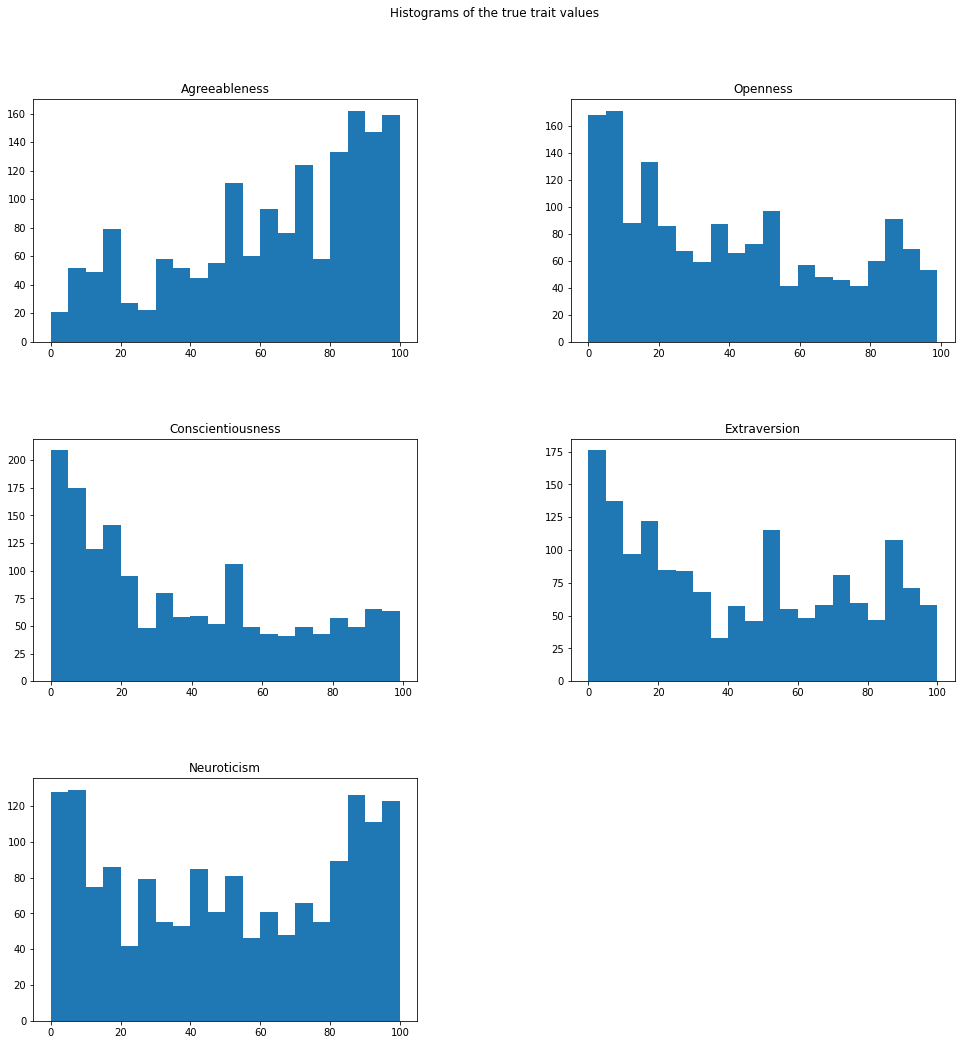

In [18]:
# true histogram plots
all_hist_true(df)

In [19]:
# %%javascript
# IPython.OutputArea.auto_scroll_threshold = 1000;

### check results on train set with k nearest neighbor algorithm

Trait to predict:  openness


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       355
           1       1.00      1.00      1.00       849

    accuracy                           1.00      1204
   macro avg       1.00      1.00      1.00      1204
weighted avg       1.00      1.00      1.00      1204



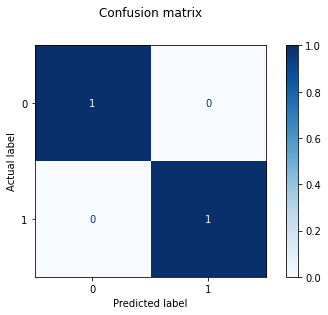

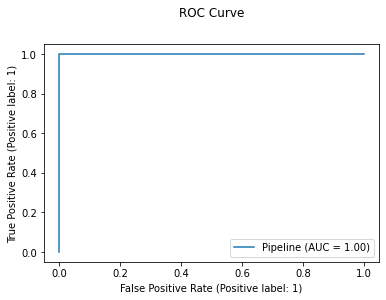

Trait to predict:  conscientiousness


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       746
           1       1.00      1.00      1.00       458

    accuracy                           1.00      1204
   macro avg       1.00      1.00      1.00      1204
weighted avg       1.00      1.00      1.00      1204



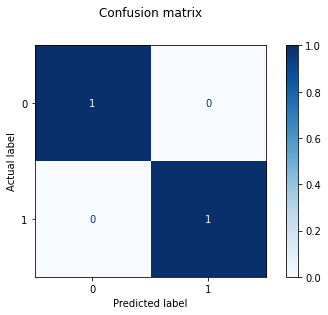

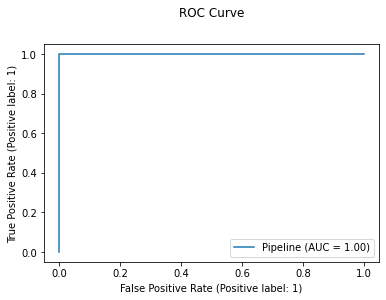

Trait to predict:  extraversion


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       779
           1       1.00      1.00      1.00       425

    accuracy                           1.00      1204
   macro avg       1.00      1.00      1.00      1204
weighted avg       1.00      1.00      1.00      1204



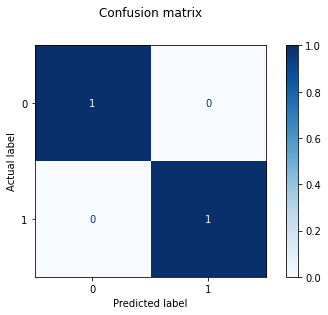

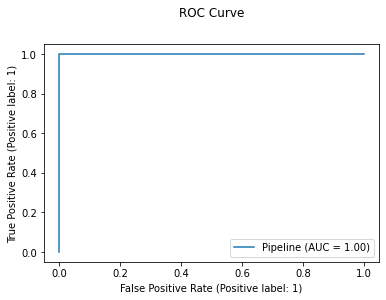

Trait to predict:  agreeableness


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       680
           1       1.00      1.00      1.00       524

    accuracy                           1.00      1204
   macro avg       1.00      1.00      1.00      1204
weighted avg       1.00      1.00      1.00      1204



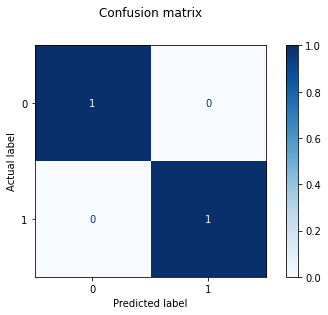

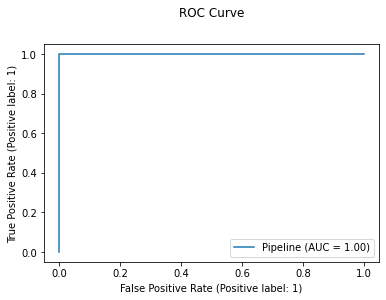

Trait to predict:  neuroticism


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       592
           1       1.00      1.00      1.00       612

    accuracy                           1.00      1204
   macro avg       1.00      1.00      1.00      1204
weighted avg       1.00      1.00      1.00      1204



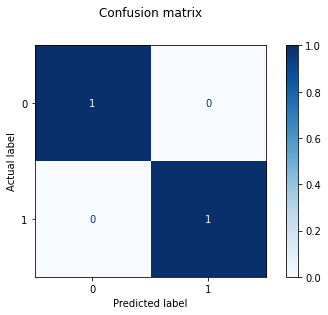

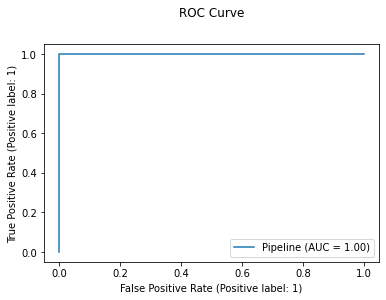

In [20]:
classify(df, 'knn', 'binary', trainscores=True, plotting=True, weighted=False, detailed=False)

### Logistic regression

Trait to predict:  openness


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Classification report: 
               precision    recall  f1-score   support

           0       0.26      0.20      0.22       105
           1       0.74      0.79      0.76       297

    accuracy                           0.64       402
   macro avg       0.50      0.50      0.49       402
weighted avg       0.61      0.64      0.62       402



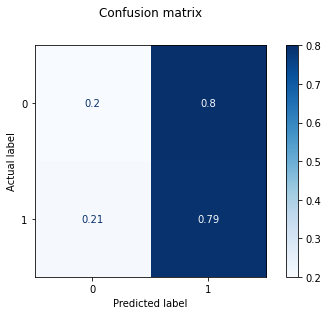

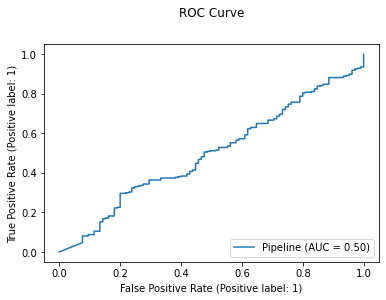

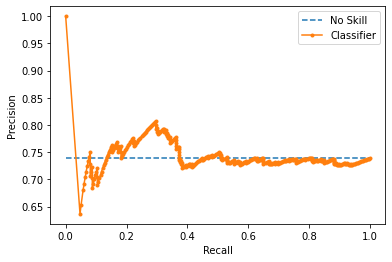

Trait to predict:  conscientiousness


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Classification report: 
               precision    recall  f1-score   support

           0       0.64      0.71      0.67       251
           1       0.41      0.33      0.36       151

    accuracy                           0.57       402
   macro avg       0.52      0.52      0.52       402
weighted avg       0.55      0.57      0.56       402



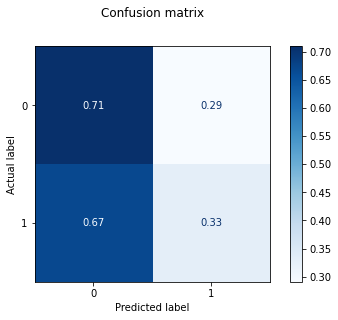

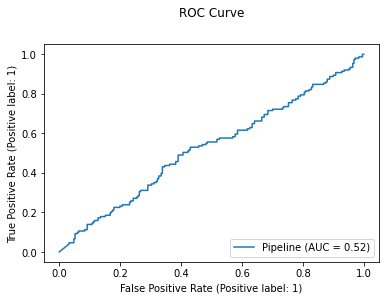

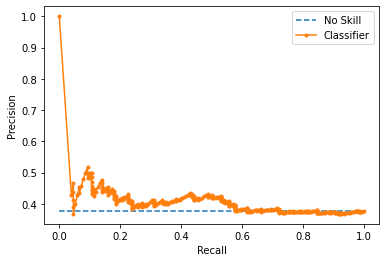

Trait to predict:  extraversion


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Classification report: 
               precision    recall  f1-score   support

           0       0.69      0.72      0.70       258
           1       0.45      0.41      0.43       144

    accuracy                           0.61       402
   macro avg       0.57      0.56      0.56       402
weighted avg       0.60      0.61      0.60       402



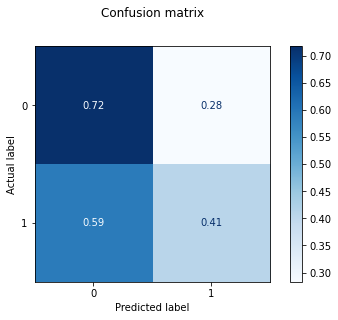

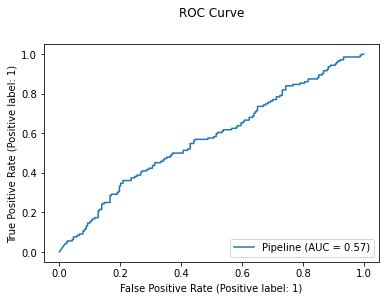

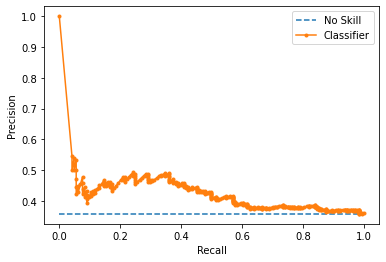

Trait to predict:  agreeableness


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Classification report: 
               precision    recall  f1-score   support

           0       0.54      0.60      0.57       225
           1       0.40      0.34      0.37       177

    accuracy                           0.49       402
   macro avg       0.47      0.47      0.47       402
weighted avg       0.48      0.49      0.48       402



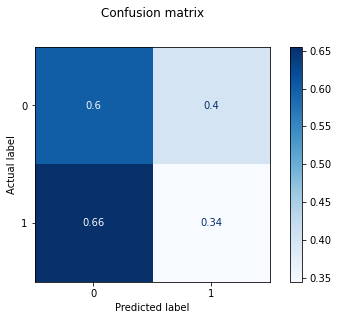

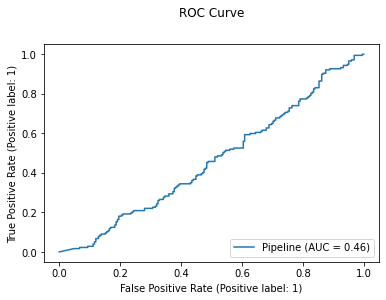

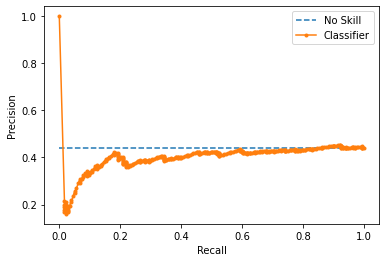

Trait to predict:  neuroticism


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Classification report: 
               precision    recall  f1-score   support

           0       0.52      0.47      0.49       201
           1       0.52      0.57      0.54       201

    accuracy                           0.52       402
   macro avg       0.52      0.52      0.52       402
weighted avg       0.52      0.52      0.52       402



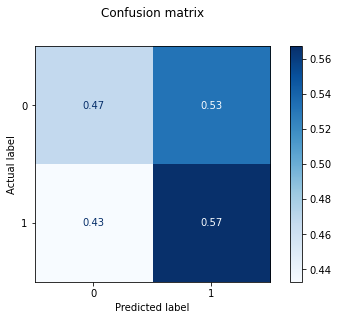

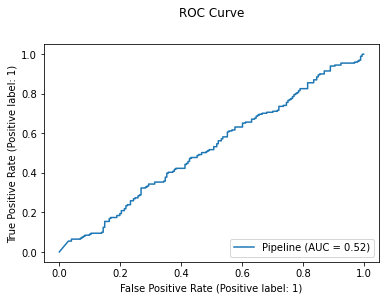

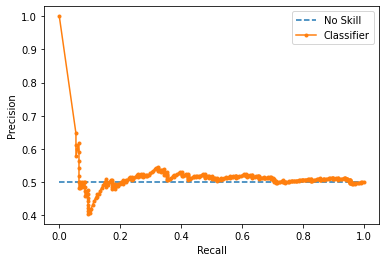

In [21]:
classify(df, 'log', 'binary', plotting=True)

Trait to predict:  openness


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Classification report: 
               precision    recall  f1-score   support

           0       0.26      0.33      0.29       105
           1       0.74      0.66      0.70       297

    accuracy                           0.57       402
   macro avg       0.50      0.50      0.49       402
weighted avg       0.61      0.57      0.59       402



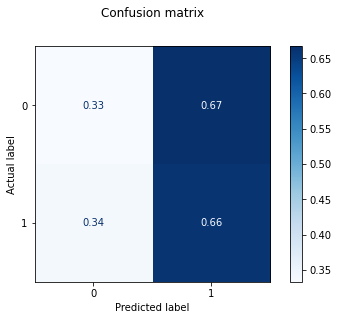

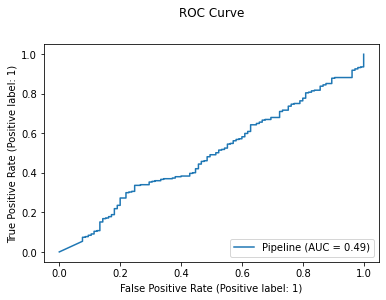

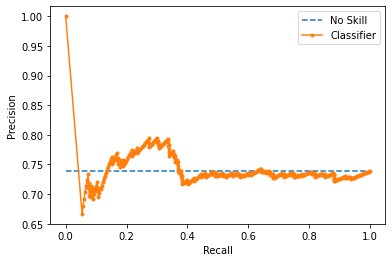

Trait to predict:  conscientiousness


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Classification report: 
               precision    recall  f1-score   support

           0       0.66      0.66      0.66       251
           1       0.43      0.42      0.43       151

    accuracy                           0.57       402
   macro avg       0.54      0.54      0.54       402
weighted avg       0.57      0.57      0.57       402



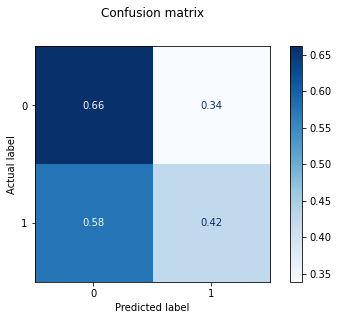

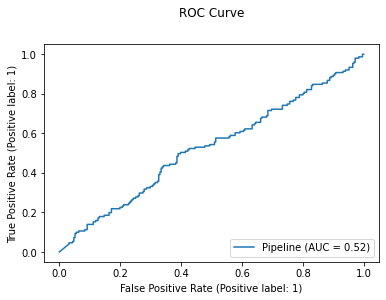

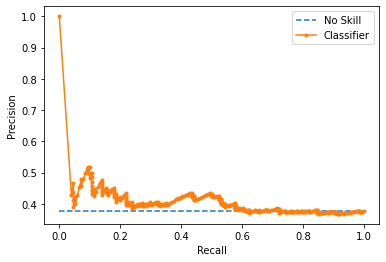

Trait to predict:  extraversion


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Classification report: 
               precision    recall  f1-score   support

           0       0.68      0.61      0.64       258
           1       0.41      0.48      0.44       144

    accuracy                           0.56       402
   macro avg       0.54      0.55      0.54       402
weighted avg       0.58      0.56      0.57       402



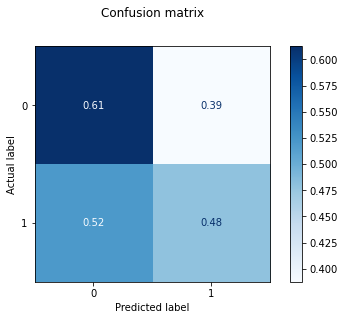

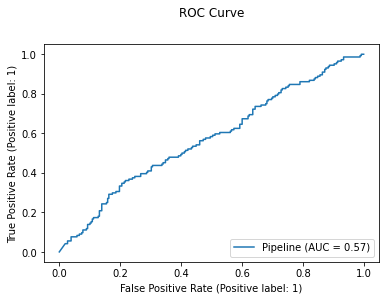

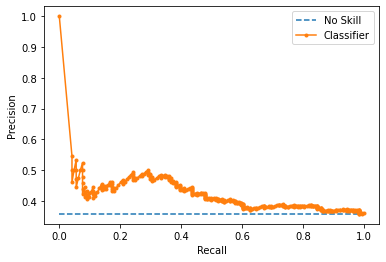

Trait to predict:  agreeableness


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Classification report: 
               precision    recall  f1-score   support

           0       0.53      0.55      0.54       225
           1       0.40      0.37      0.38       177

    accuracy                           0.47       402
   macro avg       0.46      0.46      0.46       402
weighted avg       0.47      0.47      0.47       402



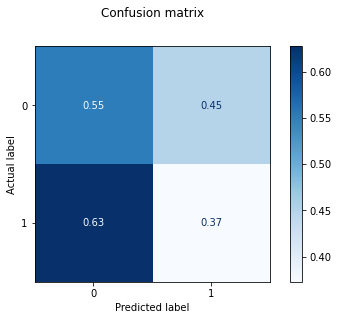

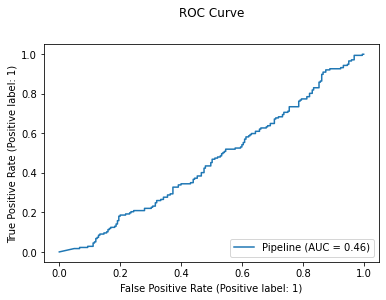

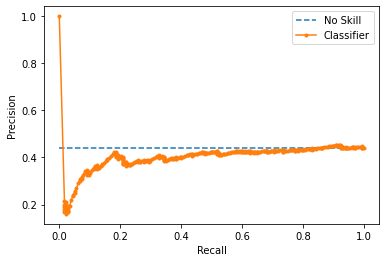

Trait to predict:  neuroticism


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Classification report: 
               precision    recall  f1-score   support

           0       0.52      0.47      0.49       201
           1       0.52      0.56      0.54       201

    accuracy                           0.52       402
   macro avg       0.52      0.52      0.52       402
weighted avg       0.52      0.52      0.52       402



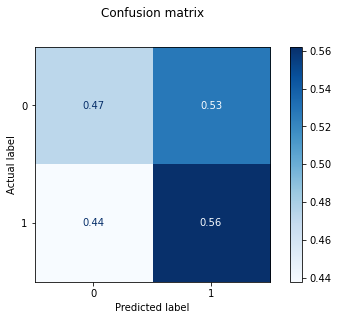

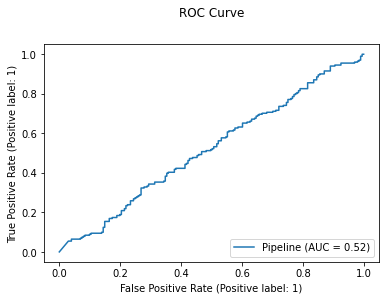

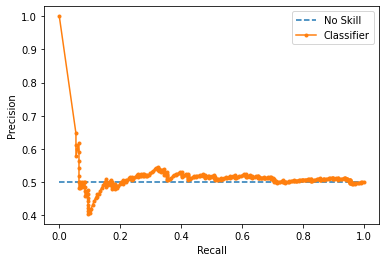

In [22]:
classify(df, 'log', 'binary', plotting=True, weighted=True)

### Logistic Regression: multiclass

Trait to predict:  openness


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Classification report: 
               precision    recall  f1-score   support

           0       0.17      0.33      0.22        43
           1       0.04      0.06      0.05        35
           2       0.13      0.08      0.10        66
           3       0.32      0.25      0.28       101
           4       0.43      0.41      0.42       157

    accuracy                           0.28       402
   macro avg       0.22      0.22      0.21       402
weighted avg       0.29      0.28      0.28       402



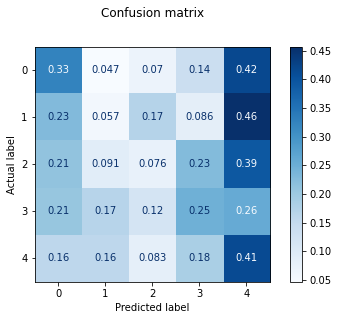

Trait to predict:  conscientiousness


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Classification report: 
               precision    recall  f1-score   support

           0       0.41      0.38      0.39       144
           1       0.18      0.22      0.20        63
           2       0.21      0.23      0.22        80
           3       0.22      0.17      0.19        47
           4       0.12      0.12      0.12        68

    accuracy                           0.26       402
   macro avg       0.23      0.22      0.22       402
weighted avg       0.26      0.26      0.26       402



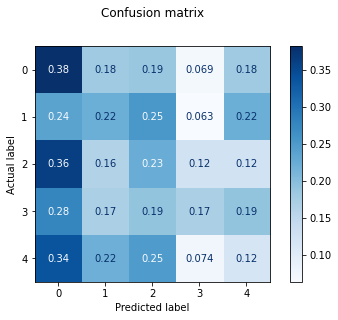

Trait to predict:  extraversion


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Classification report: 
               precision    recall  f1-score   support

           0       0.50      0.36      0.42       168
           1       0.18      0.23      0.20        62
           2       0.26      0.23      0.25        73
           3       0.07      0.11      0.09        44
           4       0.18      0.22      0.20        55

    accuracy                           0.27       402
   macro avg       0.24      0.23      0.23       402
weighted avg       0.31      0.27      0.29       402



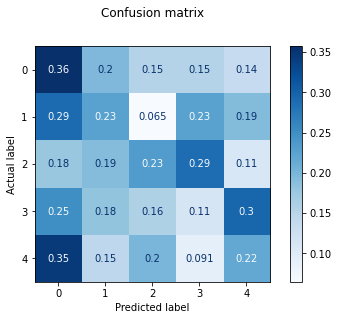

Trait to predict:  agreeableness


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Classification report: 
               precision    recall  f1-score   support

           0       0.36      0.38      0.37       138
           1       0.17      0.17      0.17        59
           2       0.18      0.17      0.18        69
           3       0.14      0.14      0.14        66
           4       0.14      0.13      0.13        70

    accuracy                           0.23       402
   macro avg       0.20      0.20      0.20       402
weighted avg       0.23      0.23      0.23       402



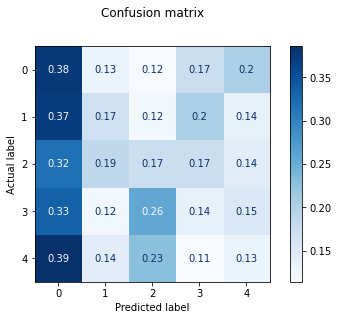

Trait to predict:  neuroticism


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Classification report: 
               precision    recall  f1-score   support

           0       0.26      0.27      0.26       101
           1       0.10      0.12      0.11        57
           2       0.17      0.15      0.16        75
           3       0.21      0.23      0.22        61
           4       0.30      0.27      0.28       108

    accuracy                           0.22       402
   macro avg       0.21      0.21      0.21       402
weighted avg       0.22      0.22      0.22       402



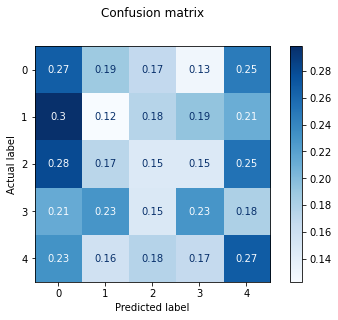

In [23]:
classify(df, 'multilog', 'multi', plotting=True, weighted=True, detailed=False)

# Results without predictor subreddit

##  binary log (without subreddit)

Trait to predict:  openness


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Classification report: 
               precision    recall  f1-score   support

           0       0.29      0.62      0.39       105
           1       0.77      0.45      0.57       297

    accuracy                           0.50       402
   macro avg       0.53      0.54      0.48       402
weighted avg       0.64      0.50      0.52       402



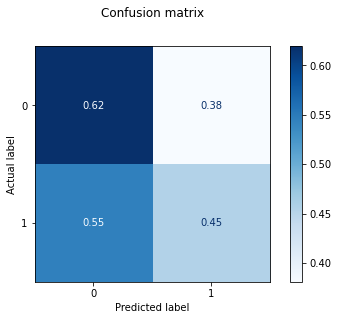

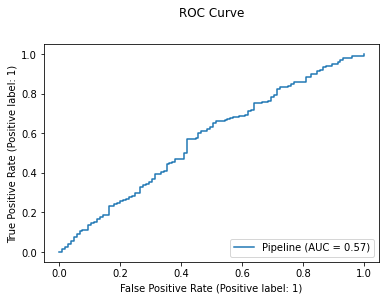

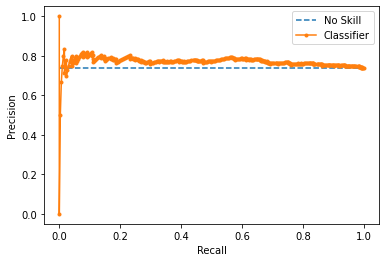

Trait to predict:  conscientiousness


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Classification report: 
               precision    recall  f1-score   support

           0       0.65      0.45      0.53       251
           1       0.39      0.59      0.47       151

    accuracy                           0.50       402
   macro avg       0.52      0.52      0.50       402
weighted avg       0.55      0.50      0.51       402



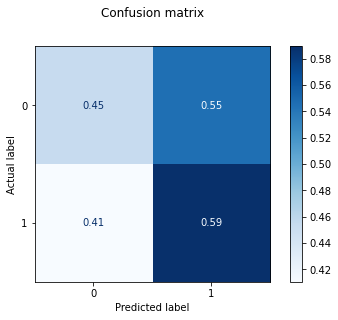

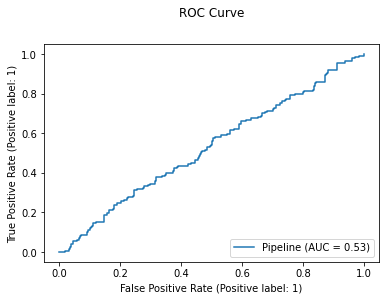

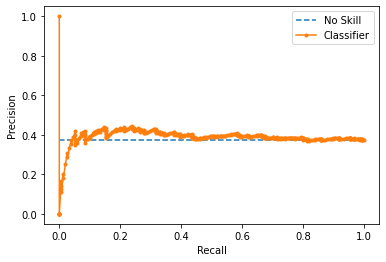

Trait to predict:  extraversion


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Classification report: 
               precision    recall  f1-score   support

           0       0.66      0.53      0.59       258
           1       0.38      0.51      0.44       144

    accuracy                           0.52       402
   macro avg       0.52      0.52      0.51       402
weighted avg       0.56      0.52      0.53       402



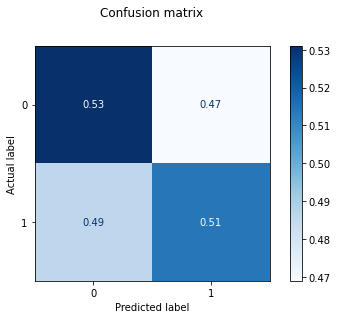

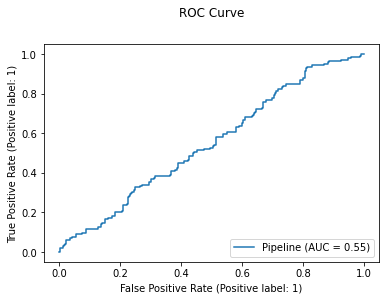

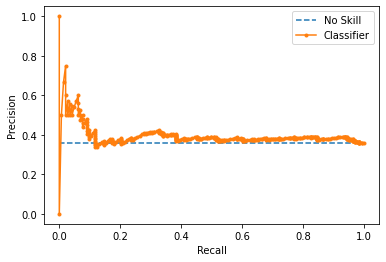

Trait to predict:  agreeableness


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Classification report: 
               precision    recall  f1-score   support

           0       0.62      0.52      0.56       225
           1       0.50      0.60      0.54       177

    accuracy                           0.55       402
   macro avg       0.56      0.56      0.55       402
weighted avg       0.57      0.55      0.56       402



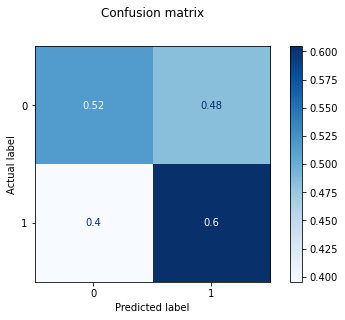

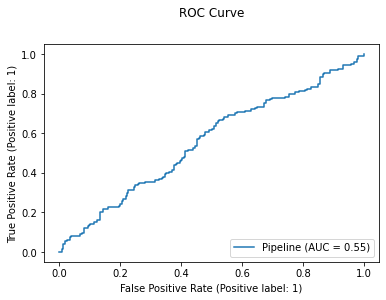

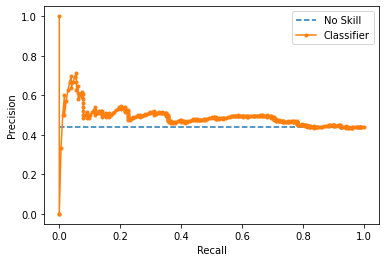

Trait to predict:  neuroticism


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Classification report: 
               precision    recall  f1-score   support

           0       0.53      0.52      0.53       201
           1       0.53      0.55      0.54       201

    accuracy                           0.53       402
   macro avg       0.53      0.53      0.53       402
weighted avg       0.53      0.53      0.53       402



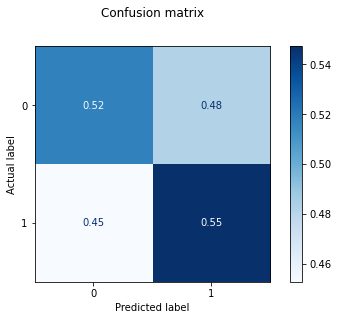

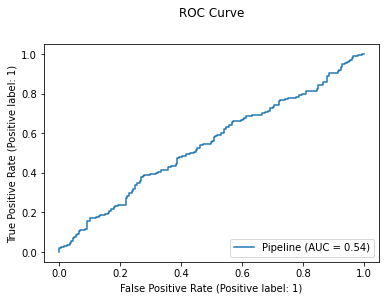

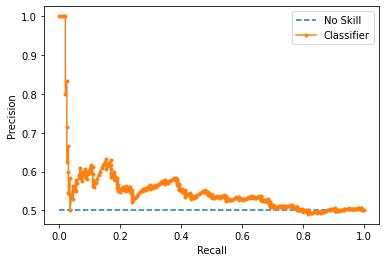

In [24]:
classify(smalldf, 'log', 'binary', plotting=True, weighted=True, detailed=False)

## multi log (without subreddit)

Trait to predict:  openness


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Classification report: 
               precision    recall  f1-score   support

           0       0.11      0.21      0.15        43
           1       0.08      0.26      0.12        35
           2       0.25      0.29      0.27        66
           3       0.30      0.21      0.25       101
           4       0.40      0.17      0.23       157

    accuracy                           0.21       402
   macro avg       0.23      0.23      0.20       402
weighted avg       0.29      0.21      0.22       402



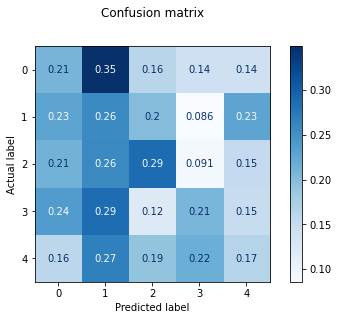

Trait to predict:  conscientiousness


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Classification report: 
               precision    recall  f1-score   support

           0       0.37      0.16      0.22       144
           1       0.10      0.11      0.11        63
           2       0.16      0.21      0.18        80
           3       0.16      0.30      0.21        47
           4       0.20      0.25      0.23        68

    accuracy                           0.19       402
   macro avg       0.20      0.21      0.19       402
weighted avg       0.24      0.19      0.20       402



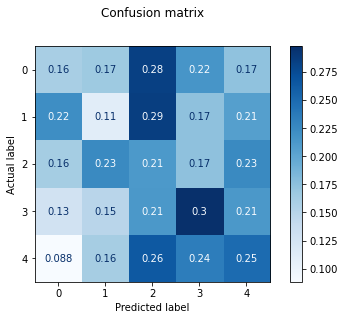

Trait to predict:  extraversion


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Classification report: 
               precision    recall  f1-score   support

           0       0.47      0.24      0.32       168
           1       0.11      0.11      0.11        62
           2       0.17      0.18      0.17        73
           3       0.08      0.11      0.09        44
           4       0.13      0.27      0.18        55

    accuracy                           0.20       402
   macro avg       0.19      0.18      0.17       402
weighted avg       0.27      0.20      0.22       402



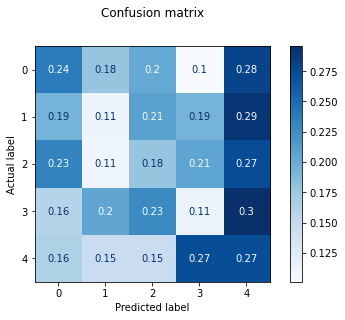

Trait to predict:  agreeableness


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Classification report: 
               precision    recall  f1-score   support

           0       0.43      0.23      0.30       138
           1       0.16      0.29      0.21        59
           2       0.13      0.10      0.11        69
           3       0.16      0.24      0.19        66
           4       0.19      0.17      0.18        70

    accuracy                           0.21       402
   macro avg       0.21      0.21      0.20       402
weighted avg       0.25      0.21      0.22       402



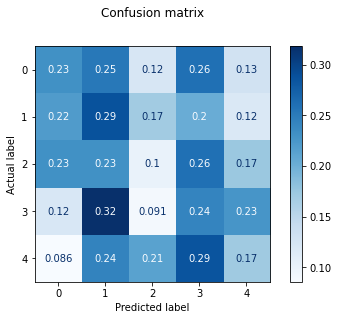

Trait to predict:  neuroticism


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Classification report: 
               precision    recall  f1-score   support

           0       0.34      0.35      0.34       101
           1       0.15      0.28      0.19        57
           2       0.22      0.12      0.16        75
           3       0.16      0.16      0.16        61
           4       0.31      0.24      0.27       108

    accuracy                           0.24       402
   macro avg       0.23      0.23      0.22       402
weighted avg       0.25      0.24      0.24       402



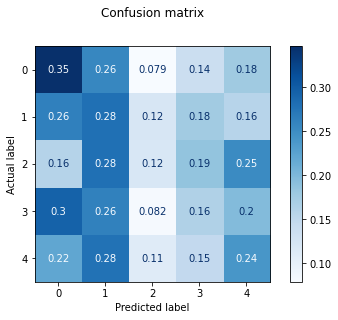

In [25]:
classify(smalldf, 'multilog', 'multi', plotting=True, weighted=True, detailed=False)

# MLP

Trait to predict:  openness


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Classification report: 
               precision    recall  f1-score   support

           0       0.14      0.14      0.14        43
           1       0.14      0.09      0.11        35
           2       0.19      0.17      0.18        66
           3       0.28      0.14      0.19       101
           4       0.39      0.58      0.47       157

    accuracy                           0.31       402
   macro avg       0.23      0.22      0.22       402
weighted avg       0.28      0.31      0.28       402



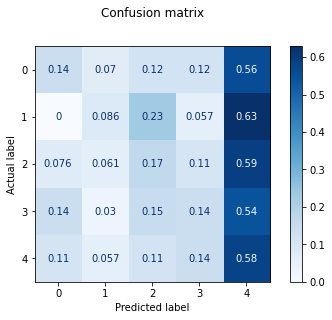

Trait to predict:  conscientiousness


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Classification report: 
               precision    recall  f1-score   support

           0       0.44      0.52      0.47       144
           1       0.18      0.19      0.18        63
           2       0.15      0.10      0.12        80
           3       0.20      0.23      0.22        47
           4       0.23      0.18      0.20        68

    accuracy                           0.29       402
   macro avg       0.24      0.24      0.24       402
weighted avg       0.27      0.29      0.28       402



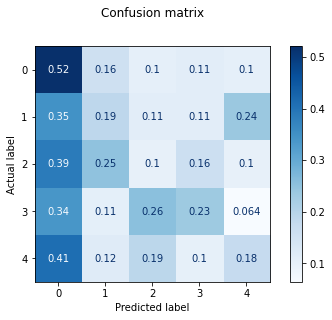

Trait to predict:  extraversion


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Classification report: 
               precision    recall  f1-score   support

           0       0.49      0.65      0.56       168
           1       0.22      0.21      0.21        62
           2       0.29      0.21      0.24        73
           3       0.14      0.09      0.11        44
           4       0.11      0.07      0.09        55

    accuracy                           0.36       402
   macro avg       0.25      0.25      0.24       402
weighted avg       0.32      0.36      0.33       402



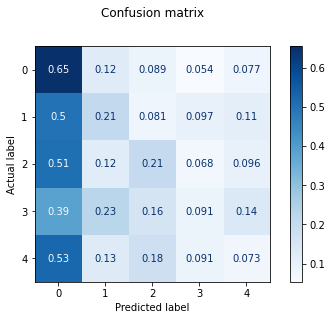

Trait to predict:  agreeableness


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Classification report: 
               precision    recall  f1-score   support

           0       0.36      0.38      0.37       138
           1       0.15      0.17      0.16        59
           2       0.06      0.03      0.04        69
           3       0.17      0.23      0.19        66
           4       0.15      0.14      0.15        70

    accuracy                           0.22       402
   macro avg       0.18      0.19      0.18       402
weighted avg       0.21      0.22      0.22       402



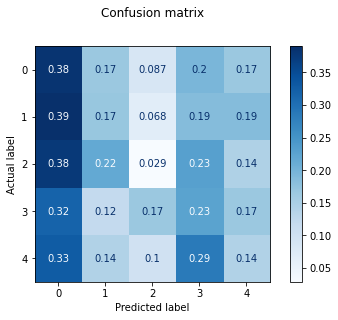

Trait to predict:  neuroticism


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Classification report: 
               precision    recall  f1-score   support

           0       0.26      0.48      0.34       101
           1       0.14      0.11      0.12        57
           2       0.24      0.11      0.15        75
           3       0.19      0.13      0.15        61
           4       0.26      0.23      0.24       108

    accuracy                           0.24       402
   macro avg       0.22      0.21      0.20       402
weighted avg       0.23      0.24      0.22       402



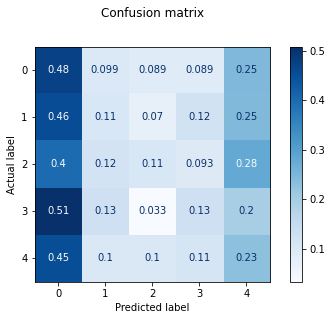

In [26]:
classify(df, 'mlp', 'multi', plotting=True)

## MLP (without subreddit)

Trait to predict:  openness


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classification report: 
               precision    recall  f1-score   support

           0       0.33      0.07      0.11       105
           1       0.74      0.95      0.83       297

    accuracy                           0.72       402
   macro avg       0.54      0.51      0.47       402
weighted avg       0.64      0.72      0.65       402



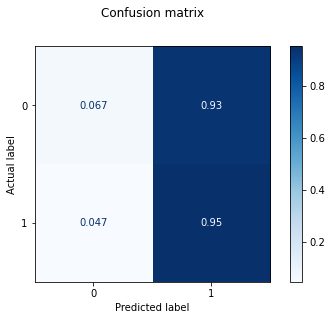

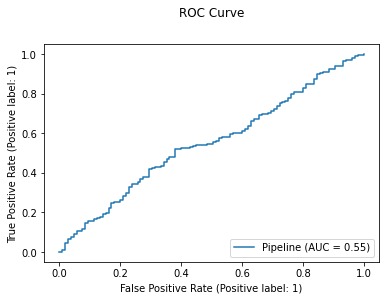

Trait to predict:  conscientiousness


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Classification report: 
               precision    recall  f1-score   support

           0       0.63      0.77      0.69       251
           1       0.38      0.24      0.29       151

    accuracy                           0.57       402
   macro avg       0.50      0.50      0.49       402
weighted avg       0.54      0.57      0.54       402



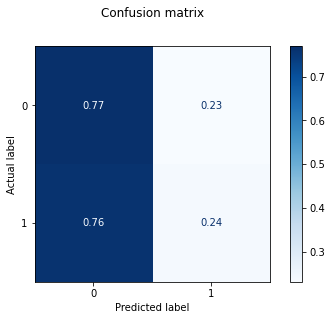

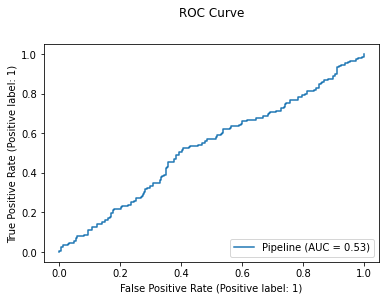

Trait to predict:  extraversion


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Classification report: 
               precision    recall  f1-score   support

           0       0.65      0.95      0.77       258
           1       0.50      0.10      0.16       144

    accuracy                           0.64       402
   macro avg       0.58      0.52      0.47       402
weighted avg       0.60      0.64      0.55       402



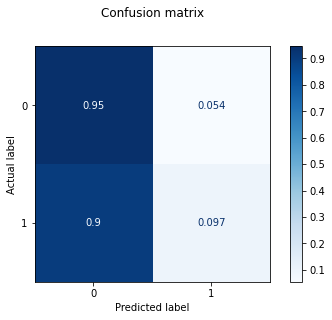

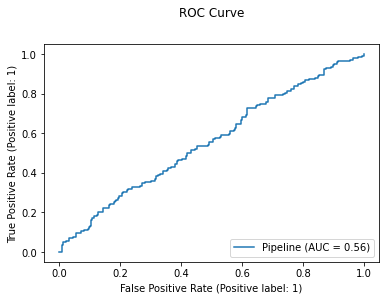

Trait to predict:  agreeableness


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Classification report: 
               precision    recall  f1-score   support

           0       0.58      0.69      0.63       225
           1       0.48      0.36      0.41       177

    accuracy                           0.54       402
   macro avg       0.53      0.52      0.52       402
weighted avg       0.53      0.54      0.53       402



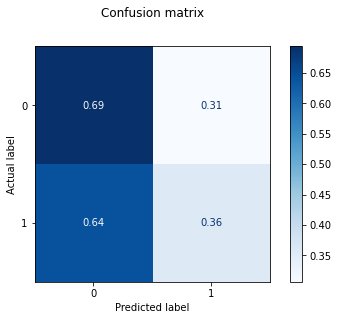

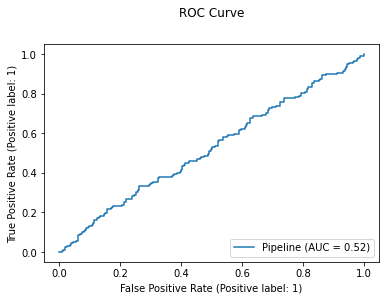

Trait to predict:  neuroticism


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classification report: 
               precision    recall  f1-score   support

           0       0.49      0.53      0.51       201
           1       0.49      0.45      0.47       201

    accuracy                           0.49       402
   macro avg       0.49      0.49      0.49       402
weighted avg       0.49      0.49      0.49       402



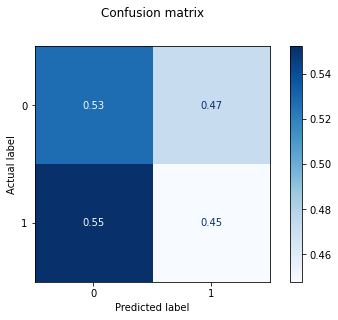

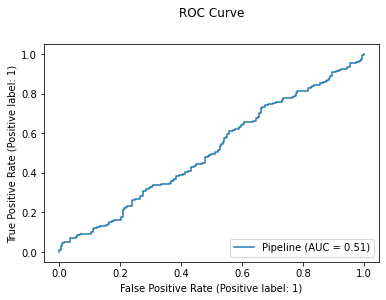

In [27]:
classify(smalldf, 'mlp', 'binary', plotting=True, weighted=False, detailed=False)